In [1]:
!pip install yfinance
!pip install ta

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import ta

# <br>1. Introduction

Let's begin with AAPL data from XXI century.

In [2]:
ticker = 'AAPL'
start_date = '2000-01-01'
end_date = '2024-01-01'

## <br>Framework
First, we build a framework to download historical market data, and perform a vectorized backtest given a trading signal.

We use "Close" as reference price time-series. Column "next_day_return" representens generated return if we buy the asset at specific date at close price, and hold it until next close price. This is convenient for the backtest.

The backtest is vectorized to reduce computational cost, and it is done with **TRUE / FALSE** signals. True means that we invest 100% of the capital at the given price, until next price data (1 day in this case).

In [3]:
def get_data(ticker, start_date, end_date):
    """
    Download historical candlestick data from yfinance database.
    
    :return:
    """    
    # Download data from Yahoo Finance
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    
    # Create columns of interest for the backtest
    data['next_day_return'] = data['Close'].shift(-1) / data['Close']
    
    # Drop nan values
    data.dropna(inplace=True)
    
    return data

In [4]:
def vectorized_backtest(data, signal, IC):
    """
    This function performs a vectorized backtest with the given dataset. 
    In the backtest, we hold the asset if the signal is TRUE until the next price data (1 day in this case). 
    Transaction costs are neglected.
    
    :param data: DataFrame with ["next_day_return", signal] columns.
    :param signal: TRUE if we hold the asset until next day, FALSE if not.
    :param IC: Invested Capital, in $.
    :return:
    """
    df = data.copy()
    
    # Percenteage of time that we LONG the asset
    long_period = 100 * len(df[df[signal]]) / len(df)
    
    # Calculate Final Capital with this strategy
    df['strategy_returns'] = 1.
    df['strategy_returns'] = df['next_day_return'].where(df[signal], 1)
    df['strategy_capital'] = df['strategy_returns'].cumprod() * IC
    final_capital = df['strategy_capital'].values[-1]
    
    # Calculate CAR and risk adjusted CAR
    N_years = (df.index.max() - df.index.min()).days / 365
    compound_annual_return = 100 * ((final_capital / IC) ** (1 / N_years) - 1)
    risk_adjusted_car = compound_annual_return / (long_period/100)
    
    # Calculate Sharpe ratio
    risk_free_rate = 0.01
    df['annualized_strategy_returns'] = df['strategy_capital'].pct_change(periods=252) * 100
    df['annualized_strategy_excess_return'] = df['annualized_strategy_returns'] - risk_free_rate
    volatility = df['annualized_strategy_excess_return'].std()
    sharpe_ratio = df['annualized_strategy_excess_return'].mean() / volatility
    
    # Calculate Sortino ratio
    negative_returns = df[df['annualized_strategy_excess_return'] < 0]['annualized_strategy_excess_return']
    sortino_ratio = df['annualized_strategy_excess_return'].mean() / negative_returns.std()
    
    # Calculate max drawdown
    cummax = df['strategy_capital'].cummax()
    df['drawdown'] = (cummax - df['strategy_capital']) / cummax
    max_drawdown = df['drawdown'].max() * 100
    
    # Numero de trades
    trades = ((df[signal] == True) & (df[signal].shift(1) == False)).sum()
    
    results = {
            'final_capital(M$)': round(final_capital/1e6, 2),
            'compound_annual_return(%)': round(compound_annual_return, 2),
            'max_drawdown(%)': round(max_drawdown, 2),
            'volatility(%)': round(volatility, 2),
            'long_period(%)': round(long_period, 2),
            'risk_adjusted_car(%)': round(risk_adjusted_car, 2),
            'sharpe_ratio(-)': round(sharpe_ratio, 2),
            'sortino_ratio(-)': round(sortino_ratio, 2),
            'number_of_trades(-)': int(trades)
        }
    return results, df

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>


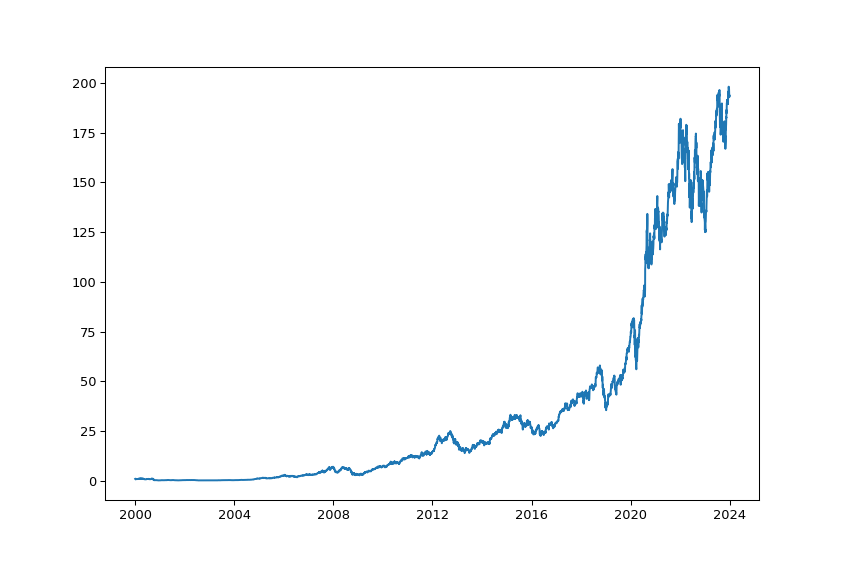

In [5]:
data = get_data(ticker, start_date, end_date)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(pd.to_datetime(data.index), data.Close)

## <br>Review of Trend-Following strategies

"Trend Following" is a trading style that attempts to capture gains through the analysis of an asset's momentum in a particular direction. Trend trading strategies assume that a security will continue to move in the same direction as it is currently trending. To detect trend in one direction, there are a variety of indicators that can be used. Curtis M. Faith did a backtest in "The way of the turtle" of some well known strategies with different assets, such as currencies, commodities and bonds, obtaining very good results.


As first step, we are implementing and backtesting some of those strategies (described in the following link: https://www.quantifiedstrategies.com/trend-following-trading-strategy/) with S&P500 since the begining of XXI century. The strategies are the following:

- ATR channel breakout
<br>
- Bollinger band
<br>
- Donchian trend
<br>
- Donchian trend with time exit
<br>
- Dual Moving Average
<br>
- Triple Moving Average

Let's plot some buys and sells with these signals, to visualize how different systems work.

### ATR Channel Breakout
Buy the asset when the price goes above an upper channel, which is calculated adding a certain amount of ATR (past volatility indicator) to a moving average. The trade is closed when the price goes below the moving average.

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>


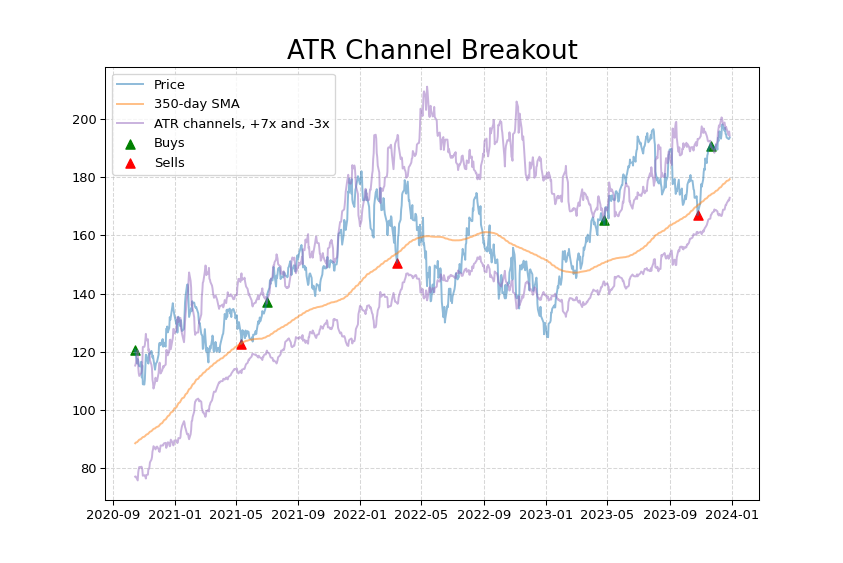

In [6]:
data = get_data(ticker, '2020-01-01', '2024-01-01')

# Simple Moving Average
data['sma'] = data['Close'].rolling(window=200).mean()

# Average True Range, volatility indicator
high_low = data['High'] - data['Low'] 
high_close = abs(data['High'] - data['Close'].shift())
low_close = abs(data['Low'] - data['Close'].shift())
TR = pd.DataFrame({'hl':high_low, 'hc':high_close, 'lc':low_close}).max(axis=1)
ATR = TR.rolling(window=7).mean()

# Lower and Upper channels
data['upper_channel'] = data['sma'] + (7 * ATR)
data['lower_channel'] = data['sma'] - (3 * ATR)

data.dropna(inplace=True)

# Backtest
hold = False
buys = []
sells = []
for cont in range(len(data)):
    if not hold and data.iloc[cont]['Close'] > data.iloc[cont]['upper_channel'] :
        buys.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = True
    elif hold and data.iloc[cont]['Close'] < data.iloc[cont]['sma']:
        sells.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = False
        
buys = np.array(buys)
sells = np.array(sells)

# Plot buy and sell signals
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(pd.to_datetime(data.index), data.Close, alpha=0.5, label='Price')
ax.plot(pd.to_datetime(data.index), data.sma, alpha=0.5, label='350-day SMA')
ax.plot(pd.to_datetime(data.index), data.upper_channel, color='C4', alpha=0.5, label='ATR channels, +7x and -3x')
ax.plot(pd.to_datetime(data.index), data.lower_channel, color='C4', alpha=0.5)

ax.scatter(pd.to_datetime(buys[:, 0]), buys[:, 1], marker='^', color='green', s=50, label='Buys')
ax.scatter(pd.to_datetime(sells[:, 0]), sells[:, 1], marker='^', color='red', s=50, label='Sells')

ax.set_title('ATR Channel Breakout', fontsize=20)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.savefig('atr.png')

### Bollinger Band
This system is the same as the ATR channel breakout, but instead of ATR as volatility indicator, it uses standard deviation of prices

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>


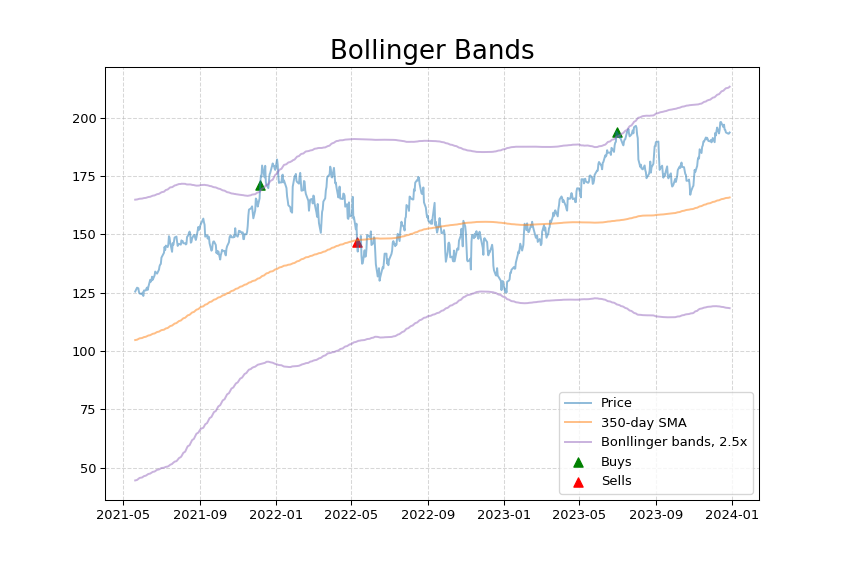

In [9]:
data = get_data(ticker, '2020-01-01', '2024-01-01')

# Simple Moving Average
data['sma'] = data['Close'].rolling(window=350).mean()

# Simple Moving Standard Deviation
data['smstd'] = data['Close'].rolling(window=350).std()

# Lower and Upper channels
data['upper_channel'] = data['sma'] + (2.5 * data['smstd'])
data['lower_channel'] = data['sma'] - (2.5 * data['smstd'])

data.dropna(inplace=True)

# Backtest
hold = False
buys = []
sells = []
for cont in range(len(data)):
    if not hold and data.iloc[cont]['Close'] > data.iloc[cont]['upper_channel'] :
        buys.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = True
    elif hold and data.iloc[cont]['Close'] < data.iloc[cont]['sma']:
        sells.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = False
        
buys = np.array(buys)
sells = np.array(sells)

# Plot buy and sell signals
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(pd.to_datetime(data.index), data.Close, alpha=0.5, label='Price')
ax.plot(pd.to_datetime(data.index), data.sma, alpha=0.5, label='350-day SMA')
ax.plot(pd.to_datetime(data.index), data.upper_channel, color='C4', alpha=0.5, label='Bonllinger bands, 2.5x')
ax.plot(pd.to_datetime(data.index), data.lower_channel, color='C4', alpha=0.5)

ax.scatter(pd.to_datetime(buys[:, 0]), buys[:, 1], marker='^', color='green', s=50, label='Buys')
ax.scatter(pd.to_datetime(sells[:, 0]), sells[:, 1], marker='^', color='red', s=50, label='Sells')

ax.set_title('Bollinger Bands', fontsize=20)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.savefig('bollinger.png')

### Donchian Trend
Buy the asset when the price is maximum compared to last days' (rolling max is the so called Donchian channel). An Uptrend filter is applied, which means that the short MA has to be above the long MA to open a trade. A 2.5xATR exit signal is used.

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>


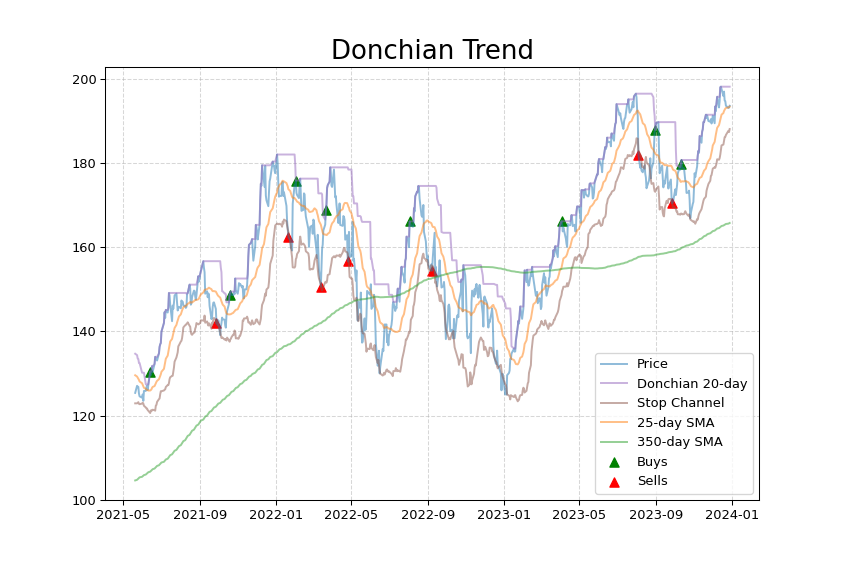

In [14]:
data = get_data(ticker, '2020-01-01', '2024-01-01')

# Exponential Moving Average
data['sma_short'] = data['Close'].rolling(window=25).mean()
data['sma_long'] = data['Close'].rolling(window=350).mean()

# Uptrend Filter
data['trend_up'] = data['sma_short'] > data['sma_long']

# Donchian Channels
data['upper_channel'] = data['Close'].rolling(window=20).max()

# Average True Range, volatility indicator
high_low = data['High'] - data['Low'] 
high_close = abs(data['High'] - data['Close'].shift())
low_close = abs(data['Low'] - data['Close'].shift())
TR = pd.DataFrame({'hl':high_low, 'hc':high_close, 'lc':low_close}).max(axis=1)
ATR = TR.rolling(window=7).mean()
data['stop_channel'] = data['sma_short'] - (2.5 * ATR)

data.dropna(inplace=True)

# Backtest
hold = False
buys = []
sells = []
for cont in range(len(data)):
    if not hold and data.iloc[cont]['Close'] == data.iloc[cont]['upper_channel']  and data.iloc[cont]['trend_up']:
        buys.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = True
    elif hold and data.iloc[cont]['Close'] < data.iloc[cont]['stop_channel']:
        sells.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = False
        
buys = np.array(buys)
sells = np.array(sells)

# Plot buy and sell signals
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(pd.to_datetime(data.index), data.Close, alpha=0.5, label='Price')
ax.plot(pd.to_datetime(data.index), data.upper_channel, color='C4', alpha=0.5, label='Donchian 20-day')
ax.plot(pd.to_datetime(data.index), data.stop_channel, color='C5', alpha=0.5, label='Stop Channel')
ax.plot(pd.to_datetime(data.index), data.sma_short, alpha=0.5, label='25-day SMA')
ax.plot(pd.to_datetime(data.index), data.sma_long, alpha=0.5, label='350-day SMA')

ax.scatter(pd.to_datetime(buys[:, 0]), buys[:, 1], marker='^', color='green', s=50, label='Buys')
ax.scatter(pd.to_datetime(sells[:, 0]), sells[:, 1], marker='^', color='red', s=50, label='Sells')

ax.set_title('Donchian Trend', fontsize=20)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.savefig('donchian.png')

### Donchian Trend with time exit
This system is the same as the previous one, but it sells the asset after a fixed amount of days since the buy signal.

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>


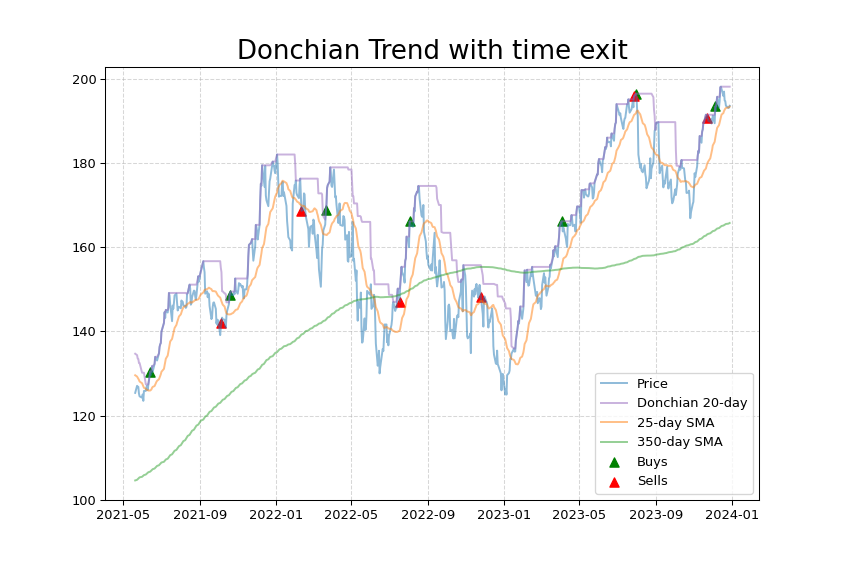

In [15]:
data = get_data(ticker, '2020-01-01', '2024-01-01')

# Exponential Moving Average
data['sma_short'] = data['Close'].rolling(window=25).mean()
data['sma_long'] = data['Close'].rolling(window=350).mean()

# Uptrend Filter
data['trend_up'] = data['sma_short'] > data['sma_long']

# Donchian Channels
data['upper_channel'] = data['Close'].rolling(window=20).max()

# Hold period
hold_period = 80

data.dropna(inplace=True)

# Backtest
hold = False
buys = []
sells = []
for cont in range(len(data)):
    if not hold and data.iloc[cont]['Close'] == data.iloc[cont]['upper_channel']  and data.iloc[cont]['trend_up']:
        buys.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        buy_cont = cont
        hold = True
    elif hold and cont >= buy_cont + hold_period:
        sells.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = False
        
buys = np.array(buys)
sells = np.array(sells)

# Plot buy and sell signals
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(pd.to_datetime(data.index), data.Close, alpha=0.5, label='Price')
ax.plot(pd.to_datetime(data.index), data.upper_channel, color='C4', alpha=0.5, label='Donchian 20-day')
ax.plot(pd.to_datetime(data.index), data.sma_short, alpha=0.5, label='25-day SMA')
ax.plot(pd.to_datetime(data.index), data.sma_long, alpha=0.5, label='350-day SMA')

ax.scatter(pd.to_datetime(buys[:, 0]), buys[:, 1], marker='^', color='green', s=50, label='Buys')
ax.scatter(pd.to_datetime(sells[:, 0]), sells[:, 1], marker='^', color='red', s=50, label='Sells')

ax.set_title('Donchian Trend with time exit', fontsize=20)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.savefig('donchian_time_exit.png')

### Dual Moving Average
Buy the asset when the short MA is above the long MA, and close the position when the condition is no longer met.

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>


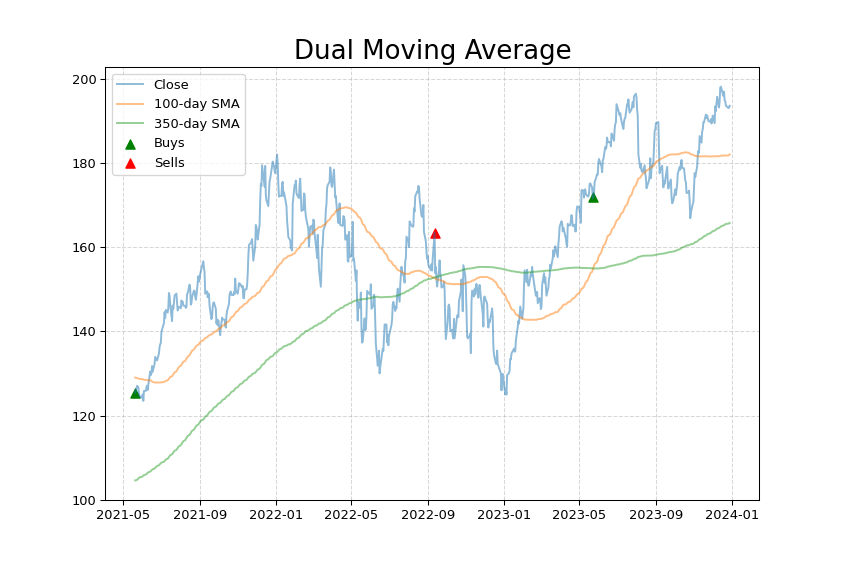

In [16]:
data = get_data(ticker, '2020-01-01', '2024-01-01')

# Exponential Moving Average
data['sma_short'] = data['Close'].rolling(window=100).mean()
data['sma_long'] = data['Close'].rolling(window=350).mean()

data.dropna(inplace=True)

# Backtest
hold = False
buys = []
sells = []
for cont in range(len(data)):
    if not hold and data.iloc[cont]['sma_short'] > data.iloc[cont]['sma_long']:
        buys.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        buy_cont = cont
        hold = True
    elif hold and data.iloc[cont]['sma_short'] < data.iloc[cont]['sma_long']:
        sells.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = False
        
buys = np.array(buys)
sells = np.array(sells)

# Plot buy and sell signals
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(pd.to_datetime(data.index), data.Close, alpha=0.5, label='Close')
ax.plot(pd.to_datetime(data.index), data.sma_short, alpha=0.5, label='100-day SMA')
ax.plot(pd.to_datetime(data.index), data.sma_long, alpha=0.5, label='350-day SMA')

ax.scatter(pd.to_datetime(buys[:, 0]), buys[:, 1], marker='^', color='green', s=50, label='Buys')
ax.scatter(pd.to_datetime(sells[:, 0]), sells[:, 1], marker='^', color='red', s=50, label='Sells')

ax.set_title('Dual Moving Average', fontsize=20)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.savefig('dual_ma.png')

### Triple Moving Average
This system is equal to the previous one, but it uses 3 moving averages, and the condition to be met is that the short MA is above the mid MA, and the mid MA is above the long MA.

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>


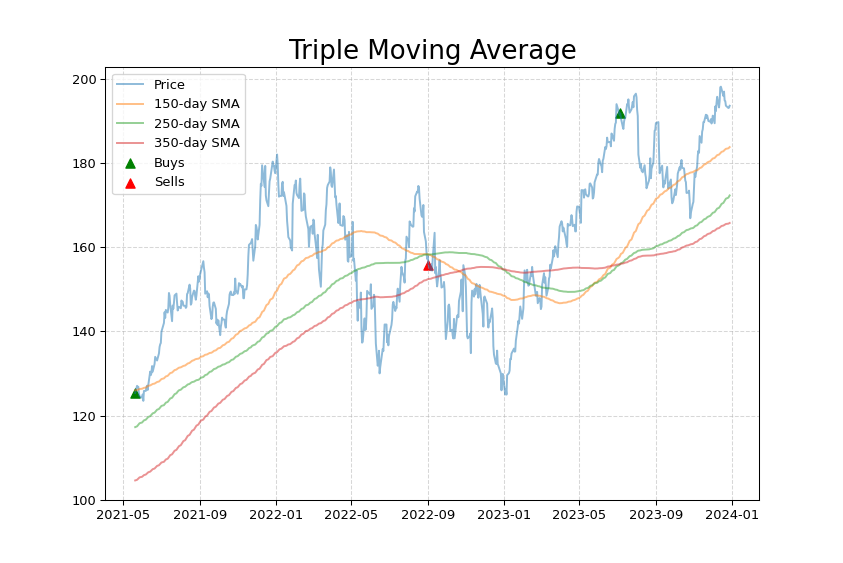

In [17]:
data = get_data(ticker, '2020-01-01', '2024-01-01')

# Exponential Moving Average
data['sma_short'] = data['Close'].rolling(window=150).mean()
data['sma_mid'] = data['Close'].rolling(window=250).mean()
data['sma_long'] = data['Close'].rolling(window=350).mean()

data.dropna(inplace=True)

# Backtest
hold = False
buys = []
sells = []
for cont in range(len(data)):
    if not hold and (data.iloc[cont]['sma_short'] > data.iloc[cont]['sma_mid'] and \
                     data.iloc[cont]['sma_mid'] > data.iloc[cont]['sma_long']):
        buys.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        buy_cont = cont
        hold = True
    elif hold and (data.iloc[cont]['sma_short'] < data.iloc[cont]['sma_mid'] or \
                   data.iloc[cont]['sma_mid'] < data.iloc[cont]['sma_long']):
        sells.append([data.iloc[cont].name, data.iloc[cont]['Close']])
        hold = False
        
buys = np.array(buys)
sells = np.array(sells)

# Plot buy and sell signals
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(pd.to_datetime(data.index), data.Close, alpha=0.5, label='Price')
ax.plot(pd.to_datetime(data.index), data.sma_short, alpha=0.5, label='150-day SMA')
ax.plot(pd.to_datetime(data.index), data.sma_mid, alpha=0.5, label='250-day SMA')
ax.plot(pd.to_datetime(data.index), data.sma_long, alpha=0.5, label='350-day SMA')

ax.scatter(pd.to_datetime(buys[:, 0]), buys[:, 1], marker='^', color='green', s=50, label='Buys')
ax.scatter(pd.to_datetime(sells[:, 0]), sells[:, 1], marker='^', color='red', s=50, label='Sells')

ax.set_title('Triple Moving Average', fontsize=20)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.savefig('triple_ma.png')

## <br>Definition of functions for every strategy
Now, let's create the functions that generate trading signals for the above-mentioned strategies. These functions take as input a DataFrame with price historical data, and returns a signal with values True or False. If the signal is True, the strategy holds the asset, and if the signal is False the strategy stays in cash.

In [18]:
def filter_action_signal(action_signal):
    """
    Filter consecutive BUY (1) or SELL (-1) signals. If there has already been a BUY signal, 
    there are no more BUY signals before we sell the asset. The same logic is applied for SELL signals.
    """
    cont = 0
    filtered_signal = []
    while True:
        if action_signal[cont] == 1 or cont == len(action_signal):
            filtered_signal.append(1)
            last = 1
            break
        filtered_signal.append(0)
        cont += 1
    
    for i in range(cont+1, len(action_signal)):
        if action_signal[i] == 1 and last == -1:
            filtered_signal.append(1)
            last = 1
        elif action_signal[i] == -1 and last == 1:
            filtered_signal.append(-1)
            last = -1
        else:
            filtered_signal.append(0)

    return np.array(filtered_signal)


def atr_channel_breakout(data):
    """
    This system generates a BUY signal if the price exceeds an upper_channel, 
    and it closes the trade when the price goes below a moving average.
    The upper_channel is calculated as a Moving Average plus a certain amount, which is mesaured in units of ATR.
    The ATR (Average True Range) is a volatility indicator.
    """
    # -----------------------------------------------------
    # STRATEGY PARAMS
    ma_window = 350
    atr_window = 7
    upper_band = 7
    lower_band = 3
    # -----------------------------------------------------
    
    # Simple Moving Average
    sma = data['Close'].rolling(window=ma_window).mean()
    
    # Calculate the Average True Range components
    # - current day high and low difference
    # - current day high and last day close difference, in abs.
    # - current day low and last day close difference, in abs.
    high_low = data['High'] - data['Low'] 
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift()) 
    
    # True Range is calculated as the max of the 3 components
    TR = pd.DataFrame({'hl':high_low, 'hc':high_close, 'lc':low_close}).max(axis=1)
    
    # Average True Range is the a SMA of the TR
    ATR = TR.rolling(window=atr_window).mean()
    
    # Define Upper and Lower channel
    upper_channel = sma + (upper_band * ATR)
    lower_channel = sma - (lower_band * ATR)
    
    # Action signal of 1 if we open LONG, -1 if we close LONG, and 0 if we do nothing
    action_signal = np.zeros(len(data))
    long_entry = data['Close'] > upper_channel
    long_exit = data['Close'] < sma
    action_signal[long_entry] = 1
    action_signal[long_exit] = -1
    action_signal = filter_action_signal(action_signal)
    
    signal = action_signal.cumsum() > 0
    
    return signal


def bollinger_band(data):
    """
    This system generates a BUY signal if the price exceeds an upper_channel, 
    and it closes the trade when the price goes below a lower_channel.
    The upper_channel is calculated as a Moving Average plus a certain amount, which is mesaured in units of 
    rolling Standard Deviation.
    """
    # -----------------------------------------------------
    # STRATEGY PARAMS
    ma_window = 350
    std_window = 350
    upper_band = 2.5
    lower_band = 2.5
    # -----------------------------------------------------
    
    # Simple Moving Average
    sma = data['Close'].rolling(window=ma_window).mean()

    # Simple Moving Standard Deviation
    smstd = data['Close'].rolling(window=std_window).std()

    # Calculate the upper and lower Bollinger Bands
    upper_channel = sma + (upper_band * smstd)
    lower_channel = sma - (lower_band * smstd)

    # Action signal of 1 if we open LONG, -1 if we close LONG, and 0 if we do nothing
    action_signal = np.zeros(len(data))
    long_entry = data['Close'] > upper_channel
    long_exit = data['Close'] < lower_channel
    action_signal[long_entry] = 1
    action_signal[long_exit] = -1
    action_signal = filter_action_signal(action_signal)
    
    signal = action_signal.cumsum() > 0
            
    return signal


def donchian_trend(data):
    """
    This system generates a BUY signal if the price exceeds an upper channel (Donchian Channels).
    The Donchian upper channel is calculated as the maximum price over tha last days. 
    There is a "Trend Filter" applied. So, to open a trade, the short-term MA has to be above the long-term MA.
    The trade is closed when the price goes below the medium channel.
    """
    # -----------------------------------------------------
    # STRATEGY PARAMS
    short_window = 25
    long_window = 350
    max_min_price_window = 20
    # -----------------------------------------------------
    
    # 25 and 350 day Exponential Moving Average
    ema_short = data['Close'].ewm(span=short_window, adjust=False).mean()
    ema_long = data['Close'].ewm(span=long_window, adjust=False).mean()

    # Determine the trend filter
    trend_up = ema_short > ema_long

    # Find new price highs over last days
    upper_channel = data['Close'].rolling(window=max_min_price_window).max()
    lower_channel = data['Close'].rolling(window=max_min_price_window).min()
    mid_channel = 0.5 * (upper_channel + lower_channel)

    # Action signal of 1 if we open LONG, -1 if we close LONG, and 0 if we do nothing
    action_signal = np.zeros(len(data))
    long_entry = trend_up & (data['Close'] == upper_channel)
    long_exit = data['Close'] <= mid_channel
    action_signal[long_entry] = 1
    action_signal[long_exit] = -1
    action_signal = filter_action_signal(action_signal)
    
    signal = action_signal.cumsum() > 0
    
    return signal


def donchian_trend_with_time_exit(data):
    """
    This system generates a BUY signal if the price exceeds an upper channel (Donchian Channels).
    The Donchian upper channel is calculated as the maximum price over tha last days. 
    There is a "Trend Filter" applied. So, to open a trade, the short-term MA has to be above the long-term MA.
    The exit strategy is time-based: close the trade after a fixed amount of days.
    """
    # -----------------------------------------------------
    # STRATEGY PARAMS
    short_window = 25
    long_window = 350
    max_price_window = 20
    time_close_window = 80
    # -----------------------------------------------------
    
    # 25 and 350 day Exponential Moving Average
    ema_short = data['Close'].ewm(span=short_window, adjust=False).mean()
    ema_long = data['Close'].ewm(span=long_window, adjust=False).mean()

    # Determine the trend filter with EMA crossover
    trend_up = ema_short > ema_long

    # Define Donchian upper channel (max price over last days)
    upper_channel = data['Close'].rolling(window=max_price_window).max()

    # Define Entry points, and set close points based on time-exit strategy
    long_entry = trend_up & (data['Close'] == upper_channel)
    i = 0
    signal = []
    while True:
        if i >= len(data):
            break
        
        if long_entry[i]:
            i += np.min([time_close_window, len(data) - len(signal) - 1])
            signal += [True] * np.min([time_close_window, len(data) - len(signal) - 1])
        
        i += 1
        signal.append(False)
    
    return signal


def dual_moving_average(data):
    """
    This system generates a BUY signal if a short-term moving average is above a long-term moving average. 
    The trade is closed when this condition is no longer met.
    """
    # -----------------------------------------------------
    # STRATEGY PARAMS
    short_window = 100
    long_window = 350
    # -----------------------------------------------------
    
    # 100 and 350 day Simple Moving Average
    sma_short = data['Close'].rolling(window=short_window).mean()
    sma_long = data['Close'].rolling(window=long_window).mean()
    
    # Define Entry and Exit points
    long_entry = sma_short > sma_long
    long_exit = sma_short < sma_long
    
    signal = long_entry & ~long_exit        
    
    return signal


def triple_moving_average(data):
    """
    This system works with 3 moving averages: short, mid and long-term. 
    If short-term MA is above mid-term MA, and mid-term MA is above long-term MA, it generates a BUY signal. 
    The trade is closed when this condition is no longer met.
    """
    # -----------------------------------------------------
    # STRATEGY PARAMS
    short_window = 150
    mid_window = 250
    long_window = 350
    # -----------------------------------------------------
    
    # 150, 250 and 350 day Simple Moving Average
    sma_short = data['Close'].rolling(window=short_window).mean()
    sma_mid = data['Close'].rolling(window=mid_window).mean()
    sma_long = data['Close'].rolling(window=long_window).mean()
    
    # Define Entry and Exit points
    long_entry = (sma_short > sma_mid) & (sma_mid > sma_long)
    long_exit = (sma_short < sma_mid) | (sma_mid < sma_long)
    
    signal = long_entry & ~long_exit
    
    return signal

# 2. Backtest of reference Trend-Following strategies
Now, let's do the backtest with historical AAPL stock data, and compare results with Buy and Hold strategy with the same asset.

In [19]:
data = get_data(ticker, start_date, end_date)

strat_names = [
    'buy_and_hold',
    'atr',
    'bollinger',
    'donchian',
    'donchian_time_exit',
    'dual_ma',
    'triple_ma'
]

# We create the signals for all the strategies
data['buy_and_hold'] = True
data['atr'] = atr_channel_breakout(data)
data['bollinger'] = bollinger_band(data)
data['donchian'] = donchian_trend(data)
data['donchian_time_exit'] = donchian_trend_with_time_exit(data)
data['dual_ma'] = dual_moving_average(data)
data['triple_ma'] = triple_moving_average(data)

data.dropna(inplace=True)

results = {}
dfs = {}
for strat_name in strat_names:
    result, df = vectorized_backtest(data, strat_name, 100_000)
    
    results[strat_name] = result
    dfs[strat_name] = df
    
results_df = pd.DataFrame([result for result in results.values()])
results_df.index = strat_names
results_df

[*********************100%%**********************]  1 of 1 completed


,final_capital(M$),compound_annual_return(%),max_drawdown(%),volatility(%),long_period(%),risk_adjusted_car(%),sharpe_ratio(-),sortino_ratio(-),number_of_trades(-)
buy_and_hold,19.26,24.51,81.80,54.21,100.00,24.51,0.69,1.97,0
atr,8.88,20.55,48.88,49.16,62.59,32.84,0.58,2.74,11
bollinger,8.64,20.42,61.54,50.06,70.46,28.98,0.58,1.92,2
donchian,7.05,19.40,23.04,31.36,39.15,49.56,0.77,5.35,106
donchian_time_exit,20.42,24.81,44.06,41.61,68.49,36.23,0.76,3.64,52
dual_ma,14.47,23.03,55.59,50.75,72.08,31.95,0.64,2.05,7
triple_ma,9.22,20.74,40.80,46.77,62.38,33.26,0.60,3.29,10


The goal of every investment strategy is to maximize returns and minimize risk. The risk can be measured in terms of maximum drawdown, or standard deviation of the returns. So, let's plot Return vs Risk with the results from the backtest.

If we look at the chart, it can be distinguished that there is a possitive correlation between return and risk, which makes sense from a theoretical perspective. In general, if the investor is willing to take on more risk, they can achieve higher returns in the long term. The baseline strategy, "Buy and Hold", is the most risky. It buys and holds the asset for the hole period, being constantly exposed to the market.

<IPython.core.display.Javascript object>


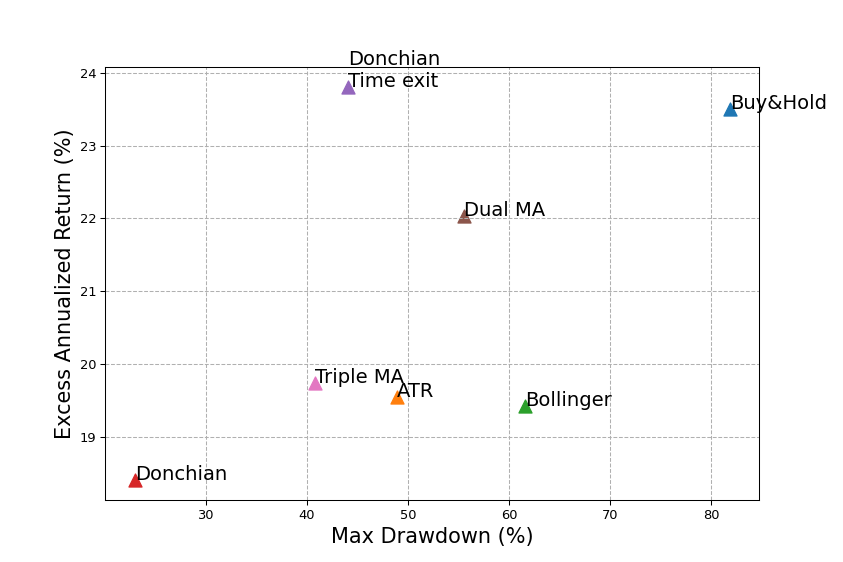

In [20]:
fig, ax = plt.subplots(figsize=(9, 6))

titles = ['Buy&Hold', 'ATR', 'Bollinger', 'Donchian', 'Donchian\nTime exit', 'Dual MA', 'Triple MA']
for title, strat_name in zip(titles, strat_names):
    x, y = results[strat_name]['max_drawdown(%)'], results[strat_name]['compound_annual_return(%)'] - 1
    ax.scatter(x, y, marker='^', s=100)
    ax.annotate(title, (x, y), fontsize=15)

ax.set_xlabel('Max Drawdown (%)', fontsize=16)
ax.set_ylabel('Excess Annualized Return (%)', fontsize=16)
plt.grid(linestyle='--')
plt.savefig('return_vs_drawdown.png')

<IPython.core.display.Javascript object>


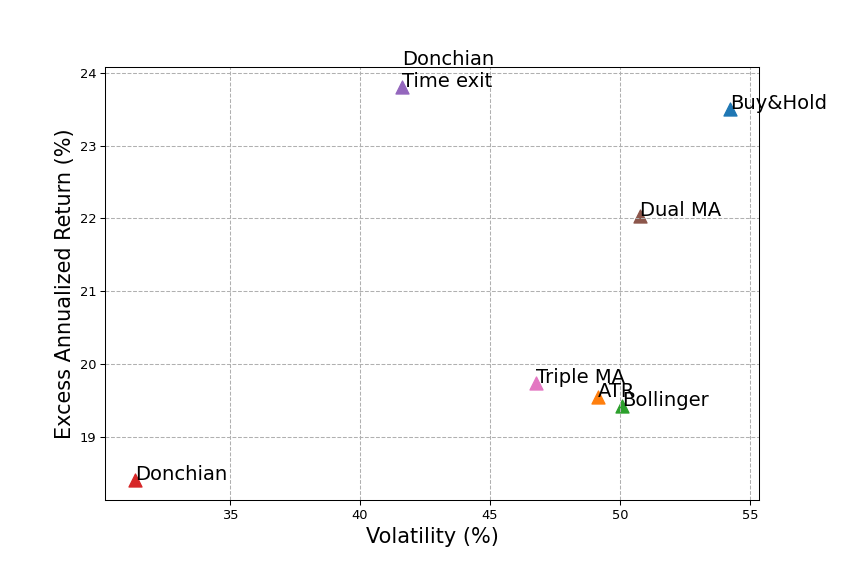

In [21]:
fig, ax = plt.subplots(figsize=(9, 6))

titles = ['Buy&Hold', 'ATR', 'Bollinger', 'Donchian', 'Donchian\nTime exit', 'Dual MA', 'Triple MA']
for title, strat_name in zip(titles, strat_names):
    x, y = results[strat_name]['volatility(%)'], results[strat_name]['compound_annual_return(%)']-1
    ax.scatter(x, y, marker='^', s=100)
    ax.annotate(title, (x, y), fontsize=15)

ax.set_xlabel('Volatility (%)', fontsize=16)
ax.set_ylabel('Excess Annualized Return (%)', fontsize=16)
plt.grid(linestyle='--')
plt.savefig('return_vs_volatility.png')

<br>Trend Follow strategies protect investors during prolonged drawdowns. When markets are declining, Trend Follow trading signals sell assets and protect against future declines. If we plot "Donchian with time exit" (which got the best results in this backtest) and "Buy and Hold", the first ramain in cash in the following periods: 2000-2004, 2008-2010, 2022-2023. While this does not work during sudden crashes with quick recoveries, these drawdowns are not as detrimental to an investor.

*(The plot is in logarithmic scale to normalize compound return effect)*

<IPython.core.display.Javascript object>


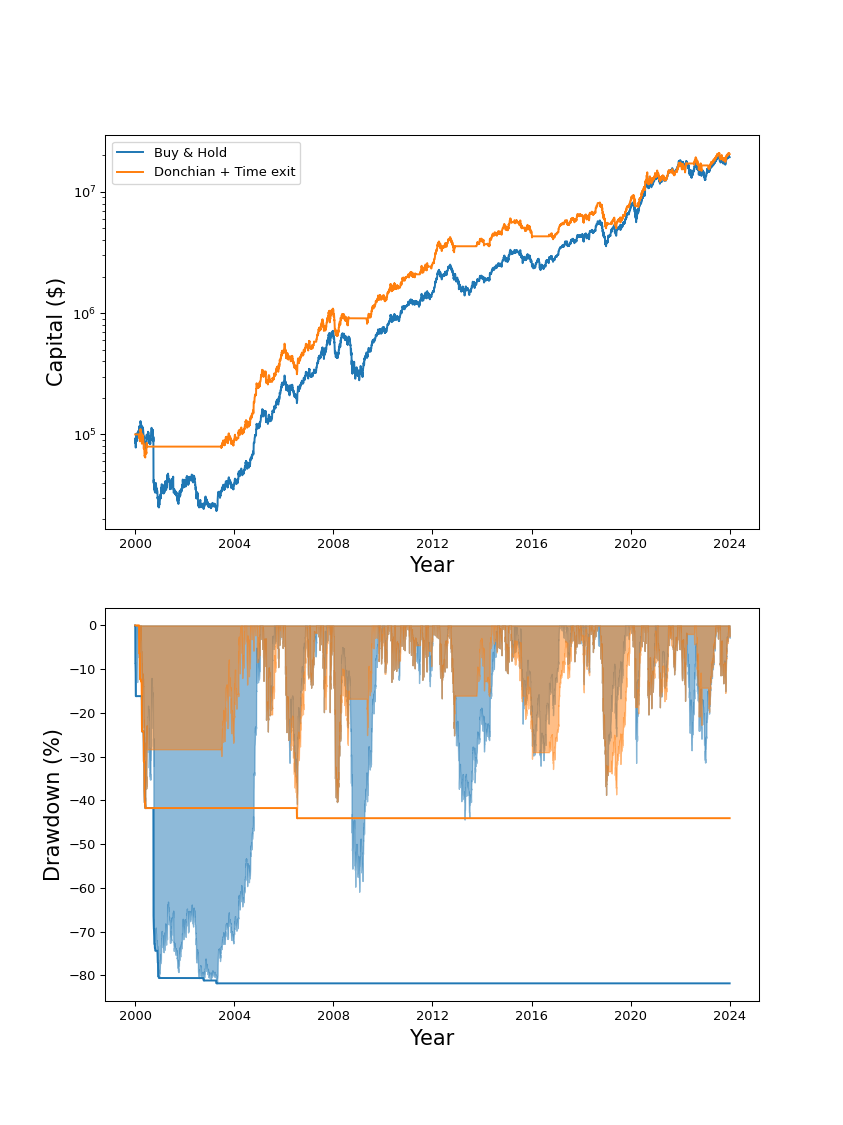

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))

# -------------------------------------------------------------------------------------
ax1.plot(pd.to_datetime(dfs['buy_and_hold'].index), dfs['buy_and_hold'].strategy_capital, label='Buy & Hold')
ax1.plot(pd.to_datetime(dfs['donchian_time_exit'].index), dfs['donchian_time_exit'].strategy_capital, 
        label='Donchian + Time exit')
ax1.set_yscale('log')
ax1.legend()

ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Capital ($)', fontsize=16)

# -------------------------------------------------------------------------------------
ax2.fill_between(pd.to_datetime(dfs['buy_and_hold'].index), -100*dfs['buy_and_hold'].drawdown, color='C0', alpha=0.5)
ax2.plot(pd.to_datetime(dfs['buy_and_hold'].index), -100*dfs['buy_and_hold'].drawdown.cummax(), color='C0')

ax2.fill_between(pd.to_datetime(dfs['donchian_time_exit'].index), -100*dfs['donchian_time_exit'].drawdown, color='C1', alpha=0.5)
ax2.plot(pd.to_datetime(dfs['donchian_time_exit'].index), -100*dfs['donchian_time_exit'].drawdown.cummax(), color='C1')

ax2.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Drawdown (%)', fontsize=16)

plt.savefig('donchian_vs_buy&hold.png')

<br>If we compare returns per unit of risk, most Trend Follow strategies did better than the "Buy and Hold".

In [23]:
df = pd.DataFrame(results)

def highlight_better_max(s):
    is_max = s == s.max()
    return ['background-color: #B7FC99' if v else '' for v in is_max]

def highlight_better_min(s):
    is_max = s == s.min()
    return ['background-color: #B7FC99' if v else '' for v in is_max]

def highlight_worst_max(s):
    is_max = s == s.max()
    return ['background-color: #FC9999' if v else '' for v in is_max]

def highlight_worst_min(s):
    is_max = s == s.min()
    return ['background-color: #FC9999' if v else '' for v in is_max]

better_max = [
    'final_capital(M$)',
    'compound_annual_return(%)',
    'risk_adjusted_car(%)',
    'sharpe_ratio(-)',
    'sortino_ratio(-)'
]
better_min = [
    'max_drawdown(%)',
    'volatility(%)',
    'long_period(%)',
    'number_of_trades(-)'
]

styled_df = df.style
styled_df = styled_df.apply(highlight_better_max, axis=1, subset=pd.IndexSlice[better_max, :])
styled_df = styled_df.apply(highlight_better_min, axis=1, subset=pd.IndexSlice[better_min, :])

styled_df = styled_df.apply(highlight_worst_max, axis=1, subset=pd.IndexSlice[better_min, :])
styled_df = styled_df.apply(highlight_worst_min, axis=1, subset=pd.IndexSlice[better_max, :])

styled_df

,buy_and_hold,atr,bollinger,donchian,donchian_time_exit,dual_ma,triple_ma
final_capital(M$),19.260000,8.880000,8.640000,7.050000,20.420000,14.470000,9.220000
compound_annual_return(%),24.510000,20.550000,20.420000,19.400000,24.810000,23.030000,20.740000
max_drawdown(%),81.800000,48.880000,61.540000,23.040000,44.060000,55.590000,40.800000
volatility(%),54.210000,49.160000,50.060000,31.360000,41.610000,50.750000,46.770000
long_period(%),100.000000,62.590000,70.460000,39.150000,68.490000,72.080000,62.380000
risk_adjusted_car(%),24.510000,32.840000,28.980000,49.560000,36.230000,31.950000,33.260000
sharpe_ratio(-),0.690000,0.580000,0.580000,0.770000,0.760000,0.640000,0.600000
sortino_ratio(-),1.970000,2.740000,1.920000,5.350000,3.640000,2.050000,3.290000
number_of_trades(-),0.000000,11.000000,2.000000,106.000000,52.000000,7.000000,10.000000


# <br>3. Volatility analysis

High volatility periods present both challenges and opportunities for Trend-Following strategies. 
- Increased market noise makes prices less predictable. Price movements that appear to be the start of a new trend might quickly reverse.
- High volatility is often associated with market downturns or recessions. During such times, markets can experience sharp drops, which imply high risk.
- On the other hand, high volatility periods can be associated with strong price movements. Trend Follow strategies benefit from capitalizing those periods.

That being said, we will try to analyze how the strategies perform, in terms of Future Average Returns, in Low and High volatility periods. For that, we will do the following:
1. Calculate asset price volatility of past days, using ATR indicator (Average True Range).
2. Calculate strategy Average Returns of next days.
3. Divide dataset in low volatility (ATR < 20% quantile), medium volatility (20% < ATR < 80% quantile) and high volatility (ATR > 80% quantile).
4. Compare mean Average Returns of the strategy in different volatility periods.

Let's take 200 day window.

<IPython.core.display.Javascript object>


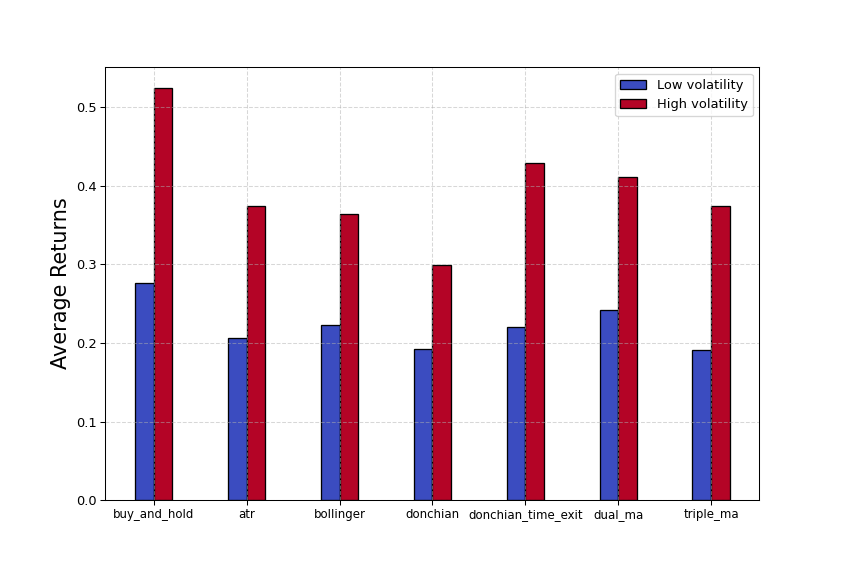

In [24]:
time_window = 252 # 1 year

MEAN_RETURNS = []
for strat_name in strat_names:
    df = dfs[strat_name].copy()

    # Calculate price past volatility, with ATR signal (Average True Range)
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift())
    low_close = abs(df['Low'] - df['Close'].shift())
    TR = pd.DataFrame({'hl':high_low, 'hc':high_close, 'lc':low_close}).max(axis=1) / data.Close
    ATR = TR.rolling(window=time_window).mean()
    df['atr'] = ATR

    # Calculate strategy Future Returns
    df['future_returns'] = df['strategy_capital'].shift(-time_window).pct_change(periods=time_window)

    # Drop nan values
    df.dropna(inplace=True)
    
    # Calculate quantile 50 of ATR, to divide dataset into low and high volatility periods
    p50 = np.percentile(df['atr'], 50)
    
    # Mean Future Returns in low and high volatility periods
    low_volatility_mean_returns = df[df['atr'] <= p50]['future_returns'].mean()
    high_volatility_mean_returns = df[df['atr'] > p50]['future_returns'].mean()
    MEAN_RETURNS.append([
        low_volatility_mean_returns,
        high_volatility_mean_returns
    ])
    
    
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# Plot results
coolwarm = plt.cm.get_cmap('coolwarm')
colors = [coolwarm(0.0), coolwarm(1.0)]
titles = ['Low volatility', 'High volatility']
xs = np.array([0.5,1.5])

fig, ax = plt.subplots(figsize=(9, 6))

for cont, mean_returns in enumerate(MEAN_RETURNS):
    if cont == 0:
        for P, mean_return, color, title in zip(xs, mean_returns, colors, titles):
            ax.bar(P, mean_return, width=1, align='center', edgecolor='k', color=color, label=title)
        xs += 5
        continue
    
    for P, mean_return, color in zip(xs, mean_returns, colors):
        ax.bar(P, mean_return, width=1, align='center', edgecolor='k', color=color)
    xs += 5

ax.set_ylabel('Average Returns', fontsize=16)
plt.legend()
ax.set_xticks([1,6,11,16,21,26,31], strat_names, fontsize=9)
plt.grid(linestyle='--', alpha=0.5)
plt.savefig('volatility_vs_returns.png')

<br>It seems that both Buy and Hold and Trend Follow strategies have in average better future returns after high volatility periods. This makes sense, as high volatility can be associated with strong market movements. However, those periods are also more risky, as high volatility is also associated with recessions. We don't want to increase strategy returns at any cost. Instead, we want to increase returns per unit of risk.

Another way to use volatility to improve Sharpe ratio is not by looking at its absolute value, but at how it changes: is it increasing or decreasing? Decreasing volatility implies that price fluctuations are becoming less extreme. In the context of an upward trend, this can indicate stability and strengthening of the trend, making it a more reliable investment. Lower volatility is often associated with increased investor confidence and a more predictable market environment.

One way to check the change in volatility is to compare a short MA with a long MA. If the volatility is decreasing, the short MA will be bellow the long MA.

<IPython.core.display.Javascript object>


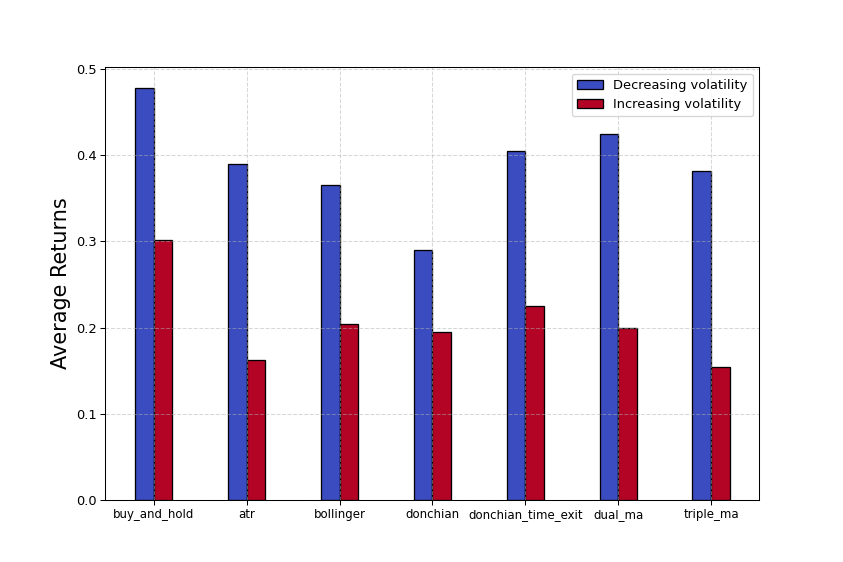

In [25]:
MEAN_RETURNS = []
for strat_name in strat_names:
    df = dfs[strat_name].copy()

    # Calculate asset price past volatility, as ATR signal (Average True Range)
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift())
    low_close = abs(df['Low'] - df['Close'].shift())
    TR = pd.DataFrame({'hl':high_low, 'hc':high_close, 'lc':low_close}).max(axis=1) / data.Close
    ATR = TR.rolling(window=time_window).mean()
    df['short_atr'] = TR.rolling(window=100).mean()
    df['long_atr'] = TR.rolling(window=350).mean()

    # Calculate strategy Future Returns
    df['future_returns'] = df['strategy_capital'].shift(-time_window).pct_change(periods=time_window)

    # Drop nan values
    df.dropna(inplace=True)
    
    # Calculate mean Future Returns when ATR is decreasing and increasing
    # If short_atr > long_atr --> volatility is increasing
    decreasing_volatility_mean_returns = df[df['short_atr'] <= df['long_atr']]['future_returns'].mean()
    increasing_volatility_mean_returns = df[df['short_atr'] > df['long_atr']]['future_returns'].mean()
    MEAN_RETURNS.append([
        decreasing_volatility_mean_returns,
        increasing_volatility_mean_returns
    ])
    
    
# -----------------------------------------------------------------------------------------
# We plot the results
coolwarm = plt.cm.get_cmap('coolwarm')
colors = [coolwarm(0.0), coolwarm(1.0)]
titles = ['Decreasing volatility', 'Increasing volatility']
xs = np.array([0.5,1.5])

fig, ax = plt.subplots(figsize=(9, 6))

for cont, mean_returns in enumerate(MEAN_RETURNS):
    if cont == 0:
        for P, mean_return, color, title in zip(xs, mean_returns, colors, titles):
            ax.bar(P, mean_return, width=1, align='center', edgecolor='k', color=color, label=title)
        xs += 5
        continue
    
    for P, mean_return, color in zip(xs, mean_returns, colors):
        ax.bar(P, mean_return, width=1, align='center', edgecolor='k', color=color)
    xs += 5

ax.set_ylabel('Average Returns', fontsize=16)
plt.legend()
ax.set_xticks([1,6,11,16,21,26,31], strat_names, fontsize=9)
plt.grid(linestyle='--', alpha=0.5)
plt.savefig('volatility_change_vs_returns.png')

Looking at this graph the pattern is clear. Periods in which volatility decreases are associated with higher future returns, and do not imply higher risk. Therefore, this indicator should improve the Sharpe ratio of Trend Following strategies.

# 4. Customized strategy

For now, we have seen that some strategies outperformed the "Buy and Hold", at least in terms returns per unit of risk. The goal is to build a conservative Trend Following strategy, that minimizes drawdowns and volatility, while capitalyzing on periods with high market uptrends. 

<br>**COMBINED ENTRY SIGNALS**
<br>As a conservative method we will use a combination of indicators for identifying uptrends and generate buy signals. This way we don't lay on a single indicator, and we diversify the strategy. The Entry signal is designed as follows:

- **Uptrend indicator**: to identify a potential uptrend, we will use the crossover of Exponential Moving Averages.
    <br>EMA (100-day) > EMA (350-day)


- **Relative Strength Indicator**: the RSI confirms the strength behind a price move, so we will filter oversold and overbought entry signals. For that we require the RSI to be in the normal range (30<RSI<70), and to be increasing (this means that the uptrend strength is increasing).
    <br>30 < RSI (30-day) < 70
    <br>RSI (5-day) > RSI (30-day)


- **Volatility filter**: Decreasing volatility often indicates more stable and predictable market movements. In the context of an upward trend, this can suggest that the trend is more likely to be sustained without abrupt reversals, making it a more reliable signal for Trend Following strategies. We will only buy the asset if the following condition is also met:
    <br> ATR (25-day) > ATR (200-day)

<br>**EXIT SIGNAL**
<br>We consider that there is no uptrend anymore if the the short EMA goes below the long EMA, or the RSI indicates overbought market. So, if one of the following conditions is met, we exit the long position.
<br> EMA (100-day) < EMA (350-day)
<br> RSI (30-day) > 70

## Let's create the signals, do the backtest, and check results

In [26]:
data = get_data(ticker, start_date, end_date) 
sp500 = get_data('SPY', start_date, end_date) # Buy and Hold SP500

# ----------------------------------------------------------------------------------------------
# Short and Long Moving Averages
data['ema_short'] = data.Close.ewm(span=100, adjust=False).mean()
data['ema_long'] = data.Close.ewm(span=350, adjust=False).mean()

# ----------------------------------------------------------------------------------------------
# Donchian channels
data['donchian_upper'] = data.Close.rolling(window=20).max()
data['donchian_lower'] = data.Close.rolling(window=20).min()
data['donchian_mid'] = 0.5 * (data['donchian_upper'] + data['donchian_lower'])

# ----------------------------------------------------------------------------------------------
# Relative Strength Indicator
data['rsi_long'] = ta.momentum.RSIIndicator(data['Close'], window=30).rsi()
data['rsi_short'] = ta.momentum.RSIIndicator(data['Close'], window=5).rsi()

# ----------------------------------------------------------------------------------------------
# Average True Range, as volatility indicator
high_low = data['High'] - data['Low']
high_close = abs(data['High'] - data['Close'].shift())
low_close = abs(data['Low'] - data['Close'].shift())
TR = pd.DataFrame({'hl':high_low, 'hc':high_close, 'lc':low_close}).max(axis=1) / data.Close
data['short_atr'] = TR.rolling(window=25).mean()
data['long_atr'] = TR.rolling(window=200).mean()

# ----------------------------------------------------------------------------------------------
# Drop nan values
data.dropna(inplace=True)
sp500 = sp500[data.index.min():data.index.max()]

# ----------------------------------------------------------------------------------------------
# Signals
data['signal_1'] = (data['ema_short'] > data['ema_long'])
# data['signal_2'] = data['Close'] == data['donchian_upper']
data['signal_2'] = (data['rsi_long'] > 30) & (data['rsi_long'] < 70) & (data['rsi_short'] > data['rsi_long'])
data['signal_3'] = data['short_atr'] < data['long_atr']
data['entry_signal'] = data['signal_1'] & data['signal_2'] & data['signal_3']
data['exit_signal'] = (data['ema_short'] < data['ema_long']) | (data['rsi_long'] > 70)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Generate Hold, Cash signal (True if hold the asset, False if stay in cash)

In [27]:
# Generate de True/False signal, True if we hold the asset, False if we stay in cash
signal = []
invested = False
for cont, (i, row) in enumerate(data.iterrows()):
    if not invested:
        # If we stay in cash, we wait for Entry signal
        if row['entry_signal']:
            invested = True
            signal.append(True)
            invest_t = cont
        else:
            signal.append(False)
    elif invested:
        # If we hold the asset, we wait for Exit signal
        if row['exit_signal']:    
            invested = False
            signal.append(False)
        else:
            signal.append(True)
            
data['signal'] = signal
sp500['signal'] = True # Buy and Hold the SPY

# <br>5. Backtest and results

In [28]:
# ------------------------------------------------------------------------------
# Vectorized backtest of STRATEGY with IC of 100k$
result, df = vectorized_backtest(data, 'signal', 100_000)

# ------------------------------------------------------------------------------
# Print results
print('TREND-FOLLOWING STRATEGY, AAPL')
print('-------------------------------------------')
descriptions = [
    'Invested Capital: ',
    'Final Capital: ',
    'Number of Trades: ',
    'Market Exposure: ',
    'Compound Annual Return (CAR): ',
    'Risk Adjusted CAR: ',
    'Max Drawdown: ',
    'Volatility: ',
    'Sharpe Ratio: ',
    'Sortino Ratio: '
]
values = [
    100,
    result['final_capital(M$)']*1e3,
    result['number_of_trades(-)'],
    result['long_period(%)'],
    result['compound_annual_return(%)'],
    result['risk_adjusted_car(%)'],
    result['max_drawdown(%)'],
    result['volatility(%)'],
    result['sharpe_ratio(-)'],
    result['sortino_ratio(-)']
]
units = [
    'k$',
    'k$',
    '',
    '%',
    '%',
    '%',
    '%',
    '%',
    '',
    ''
]
max_length = max(len(description) for description in descriptions)
for description, value, unit in zip(descriptions, values, units):
    print(f'{description.ljust(max_length)} {value:.2f}{unit}')

# ------------------------------------------------------------------------------
# BUY & HOLD SP500
data['signal_0'] = True
sp500_result, sp500_df = vectorized_backtest(sp500, 'signal', 100_000)

values = [
    100,
    sp500_result['final_capital(M$)']*1e3,
    sp500_result['number_of_trades(-)'],
    sp500_result['long_period(%)'],
    sp500_result['compound_annual_return(%)'],
    sp500_result['risk_adjusted_car(%)'],
    sp500_result['max_drawdown(%)'],
    sp500_result['volatility(%)'],
    sp500_result['sharpe_ratio(-)'],
    sp500_result['sortino_ratio(-)']
]

print('\n\nBUY & HOLD S&P 500')
print('-------------------------------------------')
max_length = max(len(description) for description in descriptions)
for description, value, unit in zip(descriptions, values, units):
    print(f'{description.ljust(max_length)} {value:.2f}{unit}')

TREND-FOLLOWING STRATEGY, AAPL
-------------------------------------------
Invested Capital:              100.00k$
Final Capital:                 7540.00k$
Number of Trades:              36.00
Market Exposure:               55.05%
Compound Annual Return (CAR):  20.47%
Risk Adjusted CAR:             37.18%
Max Drawdown:                  56.60%
Volatility:                    35.44%
Sharpe Ratio:                  0.74
Sortino Ratio:                 1.67


BUY & HOLD S&P 500
-------------------------------------------
Invested Capital:              100.00k$
Final Capital:                 340.00k$
Number of Trades:              0.00
Market Exposure:               100.00%
Compound Annual Return (CAR):  5.47%
Risk Adjusted CAR:             5.47%
Max Drawdown:                  56.47%
Volatility:                    16.54%
Sharpe Ratio:                  0.43
Sortino Ratio:                 0.61


<IPython.core.display.Javascript object>


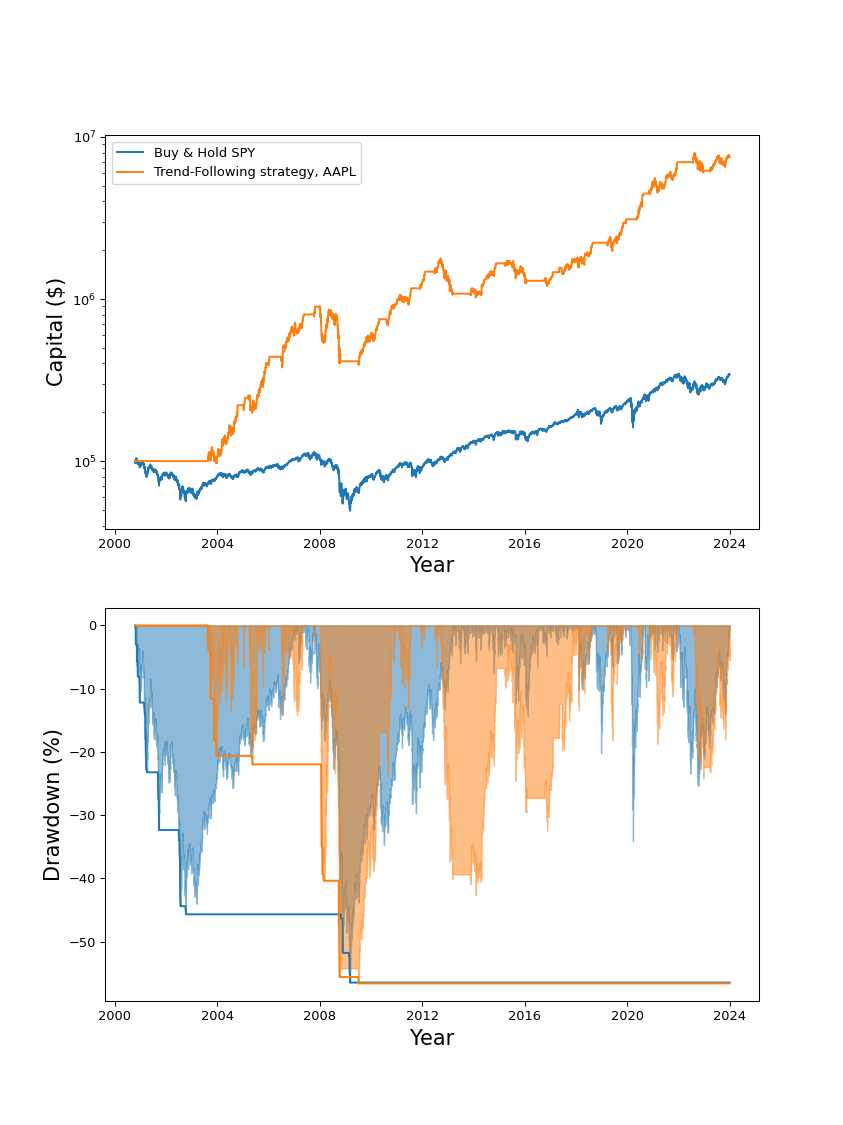

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))

# -------------------------------------------------------------------------------------
ax1.plot(pd.to_datetime(sp500_df.index), sp500_df.strategy_capital, label='Buy & Hold SPY')
ax1.plot(pd.to_datetime(df.index), df.strategy_capital, label='Trend-Following strategy, AAPL')
ax1.set_yscale('log')
ax1.legend()

ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Capital ($)', fontsize=16)

# -------------------------------------------------------------------------------------
ax2.fill_between(pd.to_datetime(sp500_df.index), -100*sp500_df.drawdown, color='C0', alpha=0.5)
ax2.plot(pd.to_datetime(sp500_df.index), -100*sp500_df.drawdown.cummax(), color='C0')

ax2.fill_between(pd.to_datetime(df.index), -100*df.drawdown, color='C1', alpha=0.5)
ax2.plot(pd.to_datetime(df.index), -100*df.drawdown.cummax(), color='C1')

ax2.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Drawdown (%)', fontsize=16)

plt.savefig('final_strat.png')